In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_6(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_6, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8,4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
    

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        
        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [5]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_6(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [6]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:39:58,811] A new study created in memory with name: no-name-04080bb1-3aad-41b8-bd28-960f79ebfa53


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:09,581] Trial 0 finished with value: -0.030472936793272357 and parameters: {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00017385316981149773, 'weight_decay': 0.046433406903303734}. Best is trial 0 with value: -0.030472936793272357.


Early stopping at epoch 72
Final MCC: -0.0305


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:15,932] Trial 1 finished with value: 0.22095446372049624 and parameters: {'dropout1': 0.0, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0003655533850521266, 'weight_decay': 0.030388321994435828}. Best is trial 1 with value: 0.22095446372049624.


Early stopping at epoch 47
Final MCC: 0.2210


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:28,939] Trial 2 finished with value: 0.2300082210846483 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.05, 'learning_rate': 0.00022157461068071852, 'weight_decay': 2.115734607313402e-05}. Best is trial 2 with value: 0.2300082210846483.


Final MCC: 0.2300


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:33,078] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.007847616771018485, 'weight_decay': 0.004168698301333751}. Best is trial 2 with value: 0.2300082210846483.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:45,440] Trial 4 finished with value: 0.08516356185954171 and parameters: {'dropout1': 0.5, 'dropout2': 0.0, 'learning_rate': 0.00015428300918247787, 'weight_decay': 1.6151382514676572e-05}. Best is trial 2 with value: 0.2300082210846483.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in 

Final MCC: 0.0852


[I 2024-12-18 13:40:50,760] Trial 6 finished with value: 0.1762186952706993 and parameters: {'dropout1': 0.1, 'dropout2': 0.0, 'learning_rate': 0.0003246006028314836, 'weight_decay': 1.4303193389440733e-05}. Best is trial 2 with value: 0.2300082210846483.


Early stopping at epoch 39
Final MCC: 0.1762


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:01,692] Trial 7 finished with value: 0.18088568649340306 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.0005924445367800429, 'weight_decay': 1.0585792432128973e-05}. Best is trial 2 with value: 0.2300082210846483.


Early stopping at epoch 82
Final MCC: 0.1809


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:14,353] Trial 8 finished with value: 0.11364937202176227 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00014049777326733868, 'weight_decay': 4.608787508198736e-05}. Best is trial 2 with value: 0.2300082210846483.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v

Final MCC: 0.1136


[I 2024-12-18 13:41:14,665] Trial 10 pruned. 
[I 2024-12-18 13:41:21,463] Trial 11 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.25, 'learning_rate': 0.0008773814145000921, 'weight_decay': 0.0635478252233136}. Best is trial 2 with value: 0.2300082210846483.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:21,615] Trial 12 pruned. 


Early stopping at epoch 52
Final MCC: 0.0000


[I 2024-12-18 13:41:21,795] Trial 13 pruned. 
[I 2024-12-18 13:41:21,947] Trial 14 pruned. 
[I 2024-12-18 13:41:22,107] Trial 15 pruned. 
[I 2024-12-18 13:41:22,257] Trial 16 pruned. 
[I 2024-12-18 13:41:34,904] Trial 17 finished with value: 0.3544775071250178 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.05, 'learning_rate': 0.00011017994671581143, 'weight_decay': 0.023941977001903543}. Best is trial 17 with value: 0.3544775071250178.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Final MCC: 0.3545


[I 2024-12-18 13:41:35,223] Trial 19 pruned. 
[I 2024-12-18 13:41:48,299] Trial 20 finished with value: 0.33146012786998486 and parameters: {'dropout1': 0.2, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0001061154601151627, 'weight_decay': 0.020765587621720975}. Best is trial 17 with value: 0.3544775071250178.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:48,483] Trial 

Final MCC: 0.3315


[I 2024-12-18 13:41:48,608] Trial 22 pruned. 
[I 2024-12-18 13:41:48,724] Trial 23 pruned. 
[I 2024-12-18 13:41:48,841] Trial 24 pruned. 
[I 2024-12-18 13:41:48,969] Trial 25 pruned. 
[I 2024-12-18 13:41:49,110] Trial 26 pruned. 
[I 2024-12-18 13:41:56,687] Trial 27 finished with value: 0.3025120184445448 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.0005155931018288929, 'weight_decay': 0.0004933082452222047}. Best is trial 17 with value: 0.3544775071250178.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

Early stopping at epoch 58
Final MCC: 0.3025


[I 2024-12-18 13:41:57,002] Trial 29 pruned. 
[I 2024-12-18 13:41:57,164] Trial 30 pruned. 
[I 2024-12-18 13:41:57,335] Trial 31 pruned. 
[I 2024-12-18 13:41:57,505] Trial 32 pruned. 
[I 2024-12-18 13:42:08,105] Trial 33 finished with value: 0.2641482193878004 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00039916519375864025, 'weight_decay': 0.03382029999180346}. Best is trial 17 with value: 0.3544775071250178.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Early stopping at epoch 82
Final MCC: 0.2641


[I 2024-12-18 13:42:08,401] Trial 35 pruned. 
[I 2024-12-18 13:42:08,554] Trial 36 pruned. 
[I 2024-12-18 13:42:08,710] Trial 37 pruned. 
[I 2024-12-18 13:42:08,881] Trial 38 pruned. 
[I 2024-12-18 13:42:09,010] Trial 39 pruned. 
[I 2024-12-18 13:42:09,154] Trial 40 pruned. 
[I 2024-12-18 13:42:22,066] Trial 41 finished with value: 0.21693970237177376 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001458823845851271, 'weight_decay': 0.024814449526988403}. Best is trial 17 with value: 0.3544775071250178.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

Final MCC: 0.2169


[I 2024-12-18 13:42:33,936] Trial 43 finished with value: 0.3675998382986562 and parameters: {'dropout1': 0.4, 'dropout2': 0.0, 'learning_rate': 0.00024426735505470216, 'weight_decay': 0.011752020640266416}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:34,090] Trial 44 pruned. 


Final MCC: 0.3676


[I 2024-12-18 13:42:39,089] Trial 45 finished with value: 0.19027076567983248 and parameters: {'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 0.0009944987580884873, 'weight_decay': 0.038611424056859606}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:39,265] Trial 46 pruned. 


Early stopping at epoch 36
Final MCC: 0.1903


[I 2024-12-18 13:42:44,733] Trial 47 finished with value: 0.3361243376191836 and parameters: {'dropout1': 0.2, 'dropout2': 0.25, 'learning_rate': 0.00037487473492092607, 'weight_decay': 0.055099500581115}. Best is trial 43 with value: 0.3675998382986562.


Early stopping at epoch 42
Final MCC: 0.3361


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:57,255] Trial 48 finished with value: 0.36735759045844235 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.00012452126710741368, 'weight_decay': 0.05445491593824558}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v

Final MCC: 0.3674


[I 2024-12-18 13:42:57,541] Trial 50 pruned. 
[I 2024-12-18 13:42:57,707] Trial 51 pruned. 
[I 2024-12-18 13:42:57,865] Trial 52 pruned. 
[I 2024-12-18 13:43:10,503] Trial 53 finished with value: 0.31258095575292827 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.05, 'learning_rate': 0.00023348023571499418, 'weight_decay': 0.0008898247814679852}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = tr

Final MCC: 0.3126


[I 2024-12-18 13:43:18,984] Trial 55 finished with value: 0.2671573952012478 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'learning_rate': 0.00023311476321750735, 'weight_decay': 0.019374276688623664}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:19,139] Trial 56 pruned. 


Early stopping at epoch 68
Final MCC: 0.2672


[I 2024-12-18 13:43:25,803] Trial 57 finished with value: 0.212796691704275 and parameters: {'dropout1': 0.2, 'dropout2': 0.05, 'learning_rate': 0.00036096924246580556, 'weight_decay': 0.0032867288578439626}. Best is trial 43 with value: 0.3675998382986562.


Early stopping at epoch 52
Final MCC: 0.2128


/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:39,300] Trial 58 finished with value: 0.33527283303300776 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'learning_rate': 0.00012663832896110983, 'weight_decay': 0.06132966360091005}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been

Final MCC: 0.3353


[I 2024-12-18 13:43:40,991] Trial 60 finished with value: 0.0 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0001237503698545222, 'weight_decay': 0.047763007338626776}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:41,146] Trial 61 pruned. 


Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 13:43:41,267] Trial 62 pruned. 
[I 2024-12-18 13:43:41,391] Trial 63 pruned. 
[I 2024-12-18 13:43:41,524] Trial 64 pruned. 
[I 2024-12-18 13:43:41,676] Trial 65 pruned. 
[I 2024-12-18 13:43:41,836] Trial 66 pruned. 
[I 2024-12-18 13:43:42,008] Trial 67 pruned. 
[I 2024-12-18 13:43:42,149] Trial 68 pruned. 
[I 2024-12-18 13:43:42,271] Trial 69 pruned. 
[I 2024-12-18 13:43:42,393] Trial 70 pruned. 
[I 2024-12-18 13:43:42,516] Trial 71 pruned. 
[I 2024-12-18 13:43:42,640] Trial 72 pruned. 
[I 2024-12-18 13:43:54,533] Trial 73 finished with value: 0.30338381952359283 and parameters: {'dropout1': 0.25, 'dropout2': 0.05, 'learning_rate': 0.0002689915845455112, 'weight_decay': 0.00015795097119441053}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

Final MCC: 0.3034


[I 2024-12-18 13:43:54,751] Trial 75 pruned. 
[I 2024-12-18 13:43:54,859] Trial 76 pruned. 
[I 2024-12-18 13:43:54,967] Trial 77 pruned. 
[I 2024-12-18 13:43:55,074] Trial 78 pruned. 
[I 2024-12-18 13:44:03,861] Trial 79 finished with value: 0.1189143148483564 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0002843942578995909, 'weight_decay': 0.00021037465779868297}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Early stopping at epoch 91
Final MCC: 0.1189


[I 2024-12-18 13:44:04,128] Trial 81 pruned. 
[I 2024-12-18 13:44:04,278] Trial 82 pruned. 
[I 2024-12-18 13:44:08,980] Trial 83 finished with value: 0.08207487271029917 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.0029724262122982873, 'weight_decay': 0.00025494386188336507}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e

Early stopping at epoch 31
Final MCC: 0.0821


[I 2024-12-18 13:44:09,274] Trial 85 pruned. 
[I 2024-12-18 13:44:20,108] Trial 86 finished with value: 0.3067824844174605 and parameters: {'dropout1': 0.2, 'dropout2': 0.45, 'learning_rate': 0.00020481598252769756, 'weight_decay': 0.0009136306548675267}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:44:20,214] Trial 87 pruned. 


Final MCC: 0.3068


[I 2024-12-18 13:44:20,322] Trial 88 pruned. 
[I 2024-12-18 13:44:20,455] Trial 89 pruned. 
[I 2024-12-18 13:44:20,618] Trial 90 pruned. 
[I 2024-12-18 13:44:20,775] Trial 91 pruned. 
[I 2024-12-18 13:44:34,353] Trial 92 finished with value: 0.3311225956359344 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.0001938501195723803, 'weight_decay': 0.0006038824766080131}. Best is trial 43 with value: 0.3675998382986562.
/tmp/ipykernel_41883/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41883/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Final MCC: 0.3311


[I 2024-12-18 13:44:34,650] Trial 94 pruned. 
[I 2024-12-18 13:44:34,790] Trial 95 pruned. 
[I 2024-12-18 13:44:34,932] Trial 96 pruned. 
[I 2024-12-18 13:44:35,054] Trial 97 pruned. 
[I 2024-12-18 13:44:35,218] Trial 98 pruned. 
[I 2024-12-18 13:44:35,382] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.0, 'learning_rate': 0.00024426735505470216, 'weight_decay': 0.011752020640266416}
Best Validation F1:  0.3675998382986562


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_6_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/100], Loss: 0.6678
Epoch [1/100], Train Loss: 0.6678, Val Loss: 0.6652
Epoch [2/100], Loss: 0.6607
Epoch [2/100], Train Loss: 0.6607, Val Loss: 0.6601
Epoch [3/100], Loss: 0.6606
Epoch [3/100], Train Loss: 0.6606, Val Loss: 0.6578
Epoch [4/100], Loss: 0.6579
Epoch [4/100], Train Loss: 0.6579, Val Loss: 0.6533
Epoch [5/100], Loss: 0.6543
Epoch [5/100], Train Loss: 0.6543, Val Loss: 0.6486
Epoch [6/100], Loss: 0.6513
Epoch [6/100], Train Loss: 0.6513, Val Loss: 0.6434
Epoch [7/100], Loss: 0.6460
Epoch [7/100], Train Loss: 0.6460, Val Loss: 0.6377
Epoch [8/100], Loss: 0.6401
Epoch [8/100], Train Loss: 0.6401, Val Loss: 0.6316
Epoch [9/100], Loss: 0.6393
Epoch [9/100], Train Loss: 0.6393, Val Loss: 0.6269
Epoch [10/100], Loss: 0.6332
Epoch [10/100], Train Loss: 0.6332, Val Loss: 0.6207
Epoch [11/100], Loss: 0.6269
Epoch [11/100], Train Loss: 0.6269, Val Loss: 0.6139
Epoch [12/100], Loss: 0.6255
Epoch [12/100], Train Loss: 0.6255, Val Loss: 0.6093
Epoch [13/100], Loss: 0.6208
Epoch

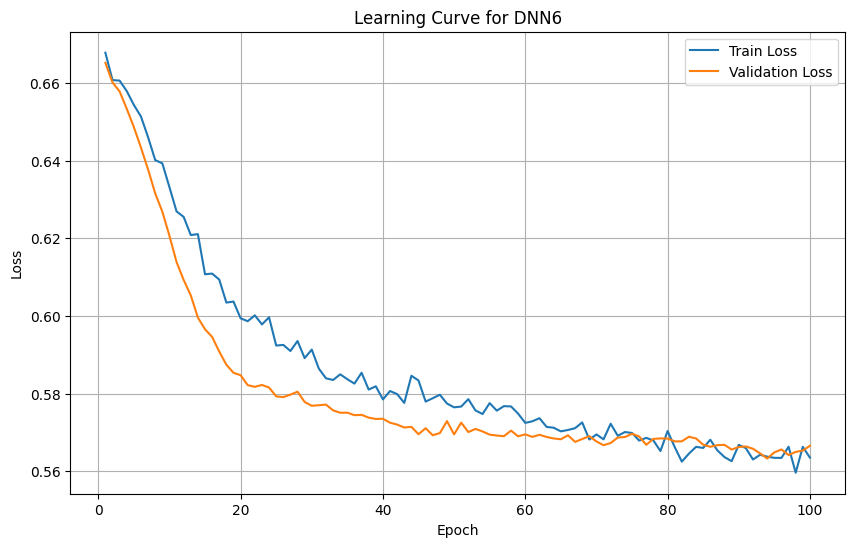

In [12]:
best_params=study.best_params
model = DNN_6(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN6')
plt.legend()
plt.grid()
plt.show()

Accuracy: 62.98%
Precision: 0.5062
Recall: 0.2477
F1 Score: 0.3326
Matthews Correlation Coefficient: 0.1307
Specificity: 0.8566


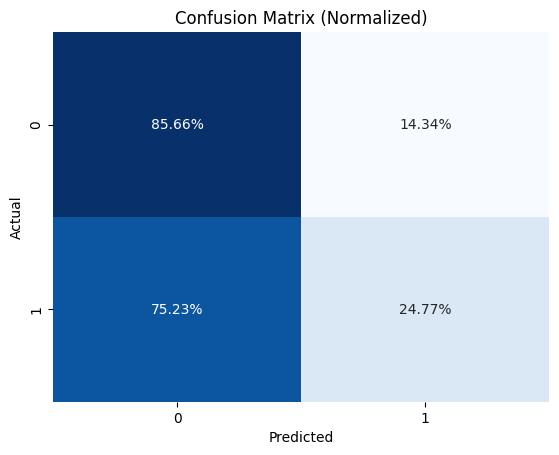

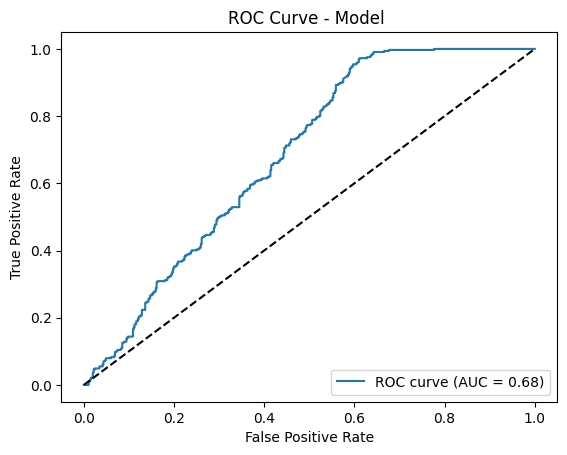

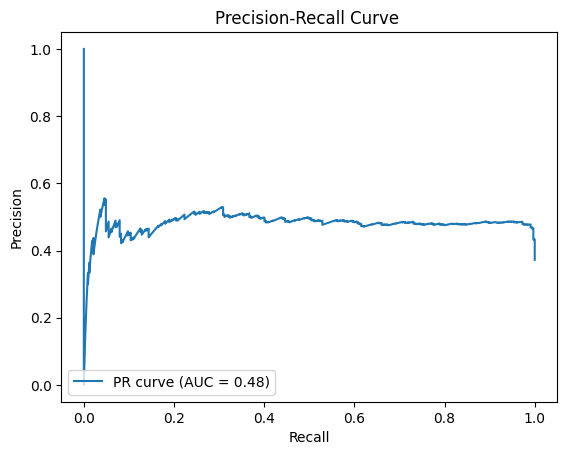

In [13]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [10]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_6.pth')




In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
           Dropout-8                    [-1, 8]               0
            Linear-9                    [-1, 4]              36
      BatchNorm1d-10                    [-1, 4]               8
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back